In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# завантаження та об'єднання наборів даних у один DataFrame
imported_data = []
for i in range(1, 32):
    df = pd.read_csv("./dds_datasets/dds_ch2_nyt/nyt{}.csv".format(i))
    imported_data.append(df)
nyt_df = pd.concat(imported_data, ignore_index=True)
nyt_df

,Age,Gender,Impressions,Clicks,Signed_In
0,36,0,3,0,1
1,73,1,3,0,1
2,30,0,3,0,1
3,49,1,3,0,1
4,47,1,11,0,1
...,...,...,...,...,...
14905860,41,1,4,0,1
14905861,0,0,5,0,0
14905862,22,1,3,0,1
14905863,59,0,5,1,1


In [3]:
# перегляд типів даних у ДатаФреймі
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14905865 entries, 0 to 14905864
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   Age          int64
 1   Gender       int64
 2   Impressions  int64
 3   Clicks       int64
 4   Signed_In    int64
dtypes: int64(5)
memory usage: 568.6 MB


In [4]:
nyt_df.sample(10)

,Age,Gender,Impressions,Clicks,Signed_In
6415115,50,0,9,0,1
2343364,22,0,4,0,1
9183682,0,0,6,0,0
10292853,33,1,5,0,1
5670683,55,0,1,0,1
976413,0,0,8,0,0
3404373,0,0,8,0,0
8339162,17,1,7,0,1
9582998,20,0,4,1,1
11961561,42,1,7,0,1


In [5]:
# перевірка ДатаФрейму на наявність порожніх значень
nyt_df.isna().sum()

Age            0
Gender         0
Impressions    0
Clicks         0
Signed_In      0
dtype: int64

In [6]:
# перейменування колонок для зручності  
nyt_df.rename(
    columns={
        "Age": "age",
        "Gender": "gender",
        "Impressions": "impressions",
        "Clicks": "clicks",
        "Signed_In": "signed_in",
    },
    inplace=True,
)

In [7]:
def parse_gender(g):
    if g == 1:
        return "Male"
    return "Female"

nyt_df["gender"] = nyt_df.gender.apply(parse_gender)

In [8]:
def parse_signed(signed_in):
    if signed_in == 1:
        return "Signed"
    return "Unsigned"


nyt_df["signed_in"] = nyt_df.signed_in.apply(parse_signed)

In [35]:
nyt_df[["gender", "signed_in"]].sample(5)

,gender,signed_in
413236,Female,Signed
564212,Female,Signed
11484602,Male,Signed
12179346,Female,Signed
8464542,Female,Unsigned


In [10]:
# визначення вікових категорій та підписів для них
bins = [0, 18, 24, 34, 44, 54, 64, float("inf")]
labels = ["<18", "18–24", "25–34", "35–44", "45–54", "55–64", "65+"]

# додавання нового стовпчику до ДатаФрейму з розподілом користувачів за віком
nyt_df["age_group"] = pd.cut(nyt_df.age, bins=bins, labels=labels, right=False)
nyt_df

,age,gender,impressions,clicks,signed_in,age_group
0,36,Female,3,0,Signed,35–44
1,73,Male,3,0,Signed,65+
2,30,Female,3,0,Signed,25–34
3,49,Male,3,0,Signed,45–54
4,47,Male,11,0,Signed,45–54
...,...,...,...,...,...,...
14905860,41,Male,4,0,Signed,35–44
14905861,0,Female,5,0,Unsigned,<18
14905862,22,Male,3,0,Signed,18–24
14905863,59,Female,5,1,Signed,55–64


In [11]:
# створення окремого ДатаФрейму для підрахунка CTR з групуванням даних по віковій категорії та гендеру
ctr_by_age_df = (
    nyt_df[["impressions", "clicks", "age_group", "gender"]]
    .groupby(["age_group", "gender"], observed=True)
    .sum()
)

# додавання нового стовпчика з розрахунком CTR (clicks through rate)
ctr_by_age_df["ctr"] = ctr_by_age_df.clicks / ctr_by_age_df.impressions
ctr_by_age_df

impressions  clicks       ctr
age_group gender                               
<18       Female     28716727  815692  0.028405
          Male        1373095   40964  0.029833
18–24     Female      2567289   28547  0.011120
          Male        2851414   31854  0.011171
25–34     Female      3960583   39757  0.010038
          Male        4403825   44078  0.010009
35–44     Female      4784496   48064  0.010046
          Male        5328839   53184  0.009980
45–54     Female      4428835   44851  0.010127
          Male        4915835   49126  0.009993
55–64     Female      3150708   60835  0.019308
          Male        3499641   67013  0.019149
65+       Female      2848502   83505  0.029315
          Male        1692279   49298  0.029131

In [12]:
ctr_by_age_df.reset_index(inplace=True)

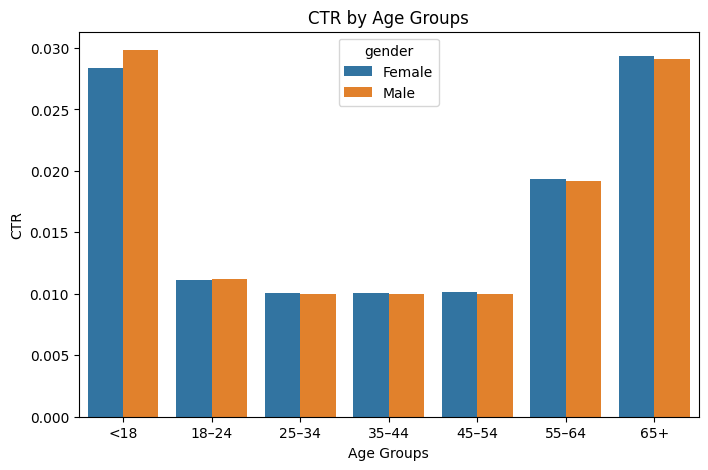

In [13]:
plt.figure(figsize=(8, 5))

sns.barplot(data=ctr_by_age_df, x="age_group", y="ctr", hue="gender")

plt.title("CTR by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("CTR");

In [14]:
# підрахунок усіх користувачів з групуванням даних по віковій категорії та гендеру
signed_by_age_df = (
    nyt_df[["signed_in", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=True)
    .count()
    .reset_index()
)

# додавання окремого стовпчика з підрахунком авторизованих корістувачів
signed_by_age_df["authorized"] = (
    nyt_df[nyt_df["signed_in"] == "Signed"]
    .groupby(["age_group", "gender"], observed=True)
    .count()
    .reset_index()["signed_in"]
)

In [15]:
# додавання окремого стовпчика з підрахунком відсотку авторизованих корістувачів
signed_by_age_df["authorized_percentage"] = (
    signed_by_age_df.authorized / signed_by_age_df.signed_in * 100
)
signed_by_age_df

,age_group,gender,signed_in,authorized,authorized_percentage
0,<18,Female,5741625,128015,2.229595
1,<18,Male,274490,274490,100.000000
2,18–24,Female,513517,513517,100.000000
3,18–24,Male,570415,570415,100.000000
4,25–34,Female,792416,792416,100.000000
5,25–34,Male,881334,881334,100.000000
6,35–44,Female,956859,956859,100.000000
7,35–44,Male,1066615,1066615,100.000000
8,45–54,Female,886538,886538,100.000000
9,45–54,Male,983874,983874,100.000000


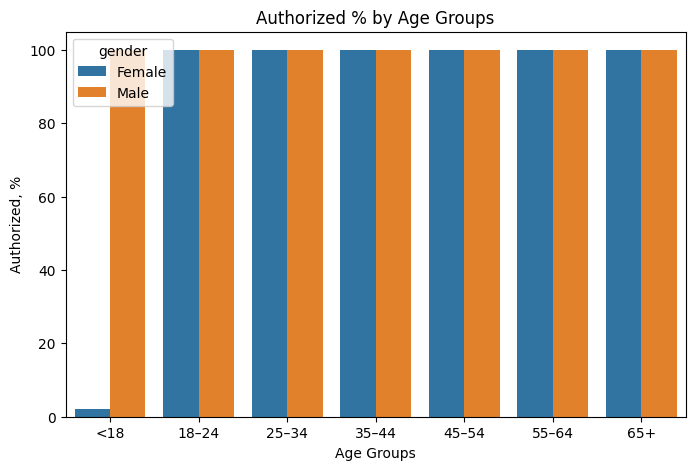

In [16]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=signed_by_age_df, x="age_group", y="authorized_percentage", hue="gender"
)

plt.title("Authorized % by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Authorized, %");

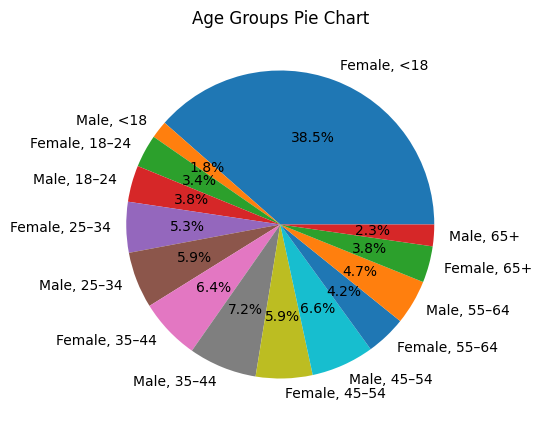

In [36]:
# відображення частки кожної вікової категорії серед усіх користувачів
plt.figure(figsize=(5, 5))

plt.pie(
    x=signed_by_age_df["signed_in"],
    labels=signed_by_age_df["gender"]
    + ", "
    + signed_by_age_df["age_group"].astype(str),
    autopct="%1.1f%%",
)

plt.title("Age Groups Pie Chart");

In [18]:
summary_df = ctr_by_age_df.copy()
summary_df

,age_group,gender,impressions,clicks,ctr
0,<18,Female,28716727,815692,0.028405
1,<18,Male,1373095,40964,0.029833
2,18–24,Female,2567289,28547,0.011120
3,18–24,Male,2851414,31854,0.011171
4,25–34,Female,3960583,39757,0.010038
5,25–34,Male,4403825,44078,0.010009
6,35–44,Female,4784496,48064,0.010046
7,35–44,Male,5328839,53184,0.009980
8,45–54,Female,4428835,44851,0.010127
9,45–54,Male,4915835,49126,0.009993


In [19]:
# додавання нового стовпчика з підрахунком к-сті показів на клік
summary_df["impressions_to_click"] = summary_df.impressions / summary_df.clicks
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click
0,<18,Female,28716727,815692,0.028405,35.205356
1,<18,Male,1373095,40964,0.029833,33.519554
2,18–24,Female,2567289,28547,0.011120,89.932007
3,18–24,Male,2851414,31854,0.011171,89.515100
4,25–34,Female,3960583,39757,0.010038,99.619765
5,25–34,Male,4403825,44078,0.010009,99.909819
6,35–44,Female,4784496,48064,0.010046,99.544274
7,35–44,Male,5328839,53184,0.009980,100.196281
8,45–54,Female,4428835,44851,0.010127,98.745513
9,45–54,Male,4915835,49126,0.009993,100.065851


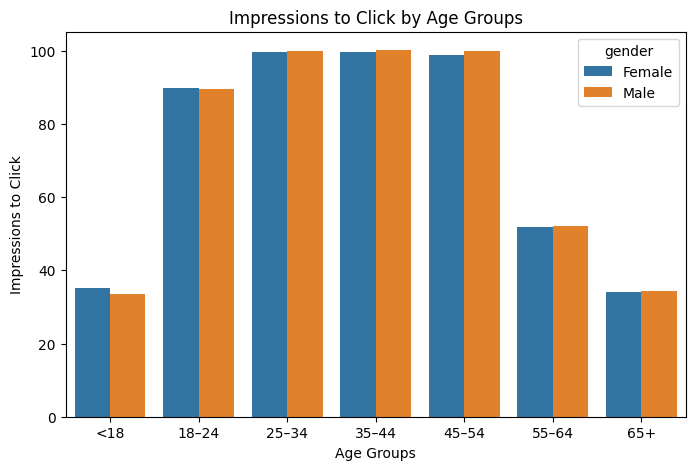

In [20]:
plt.figure(figsize=(8, 5))

sns.barplot(data=summary_df, x="age_group", y="impressions_to_click", hue="gender")

plt.title("Impressions to Click by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Impressions to Click");

In [21]:
summary_df["ctr"] = summary_df.ctr.apply(lambda x: x * 100)

# додавання нового стовпчика з середнім значенням по показам
summary_df["impressions_mean"] = (
    nyt_df[["impressions", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .mean()
    .reset_index()["impressions"]
)
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean
0,<18,Female,28716727,815692,2.840477,35.205356,5.001498
1,<18,Male,1373095,40964,2.983333,33.519554,5.002350
2,18–24,Female,2567289,28547,1.111951,89.932007,4.999424
3,18–24,Male,2851414,31854,1.117130,89.515100,4.998841
4,25–34,Female,3960583,39757,1.003817,99.619765,4.998111
5,25–34,Male,4403825,44078,1.000903,99.909819,4.996772
6,35–44,Female,4784496,48064,1.004578,99.544274,5.000210
7,35–44,Male,5328839,53184,0.998041,100.196281,4.996029
8,45–54,Female,4428835,44851,1.012704,98.745513,4.995652
9,45–54,Male,4915835,49126,0.999342,100.065851,4.996407


In [22]:
# додавання нового стовпчика з середнім значенням по переходам
summary_df["clicks_mean"] = (
    nyt_df[["clicks", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .mean()
    .reset_index()["clicks"]
)
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean,clicks_mean
0,<18,Female,28716727,815692,2.840477,35.205356,5.001498,0.142066
1,<18,Male,1373095,40964,2.983333,33.519554,5.002350,0.149237
2,18–24,Female,2567289,28547,1.111951,89.932007,4.999424,0.055591
3,18–24,Male,2851414,31854,1.117130,89.515100,4.998841,0.055844
4,25–34,Female,3960583,39757,1.003817,99.619765,4.998111,0.050172
5,25–34,Male,4403825,44078,1.000903,99.909819,4.996772,0.050013
6,35–44,Female,4784496,48064,1.004578,99.544274,5.000210,0.050231
7,35–44,Male,5328839,53184,0.998041,100.196281,4.996029,0.049862
8,45–54,Female,4428835,44851,1.012704,98.745513,4.995652,0.050591
9,45–54,Male,4915835,49126,0.999342,100.065851,4.996407,0.049931


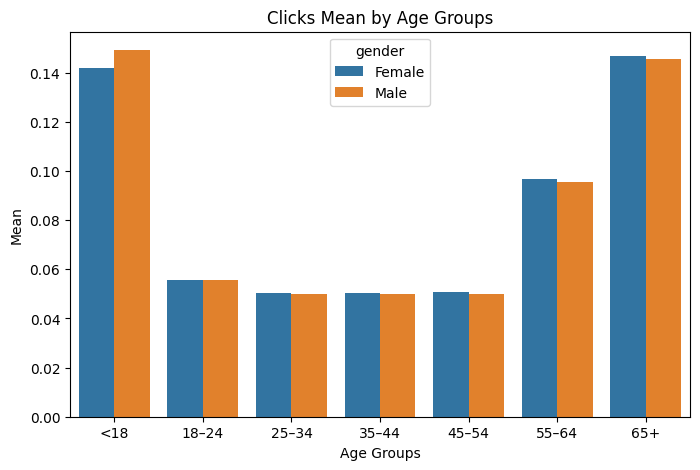

In [23]:
plt.figure(figsize=(8, 5))

sns.barplot(data=summary_df, x="age_group", y="clicks_mean", hue="gender")

plt.title("Clicks Mean by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Mean");

In [24]:
# додавання нового стовпчика з максимальним значенням по показам
summary_df["impressions_max"] = (
    nyt_df[["impressions", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .max()
    .reset_index()["impressions"]
)
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean,clicks_mean,impressions_max
0,<18,Female,28716727,815692,2.840477,35.205356,5.001498,0.142066,21
1,<18,Male,1373095,40964,2.983333,33.519554,5.002350,0.149237,18
2,18–24,Female,2567289,28547,1.111951,89.932007,4.999424,0.055591,20
3,18–24,Male,2851414,31854,1.117130,89.515100,4.998841,0.055844,18
4,25–34,Female,3960583,39757,1.003817,99.619765,4.998111,0.050172,18
5,25–34,Male,4403825,44078,1.000903,99.909819,4.996772,0.050013,19
6,35–44,Female,4784496,48064,1.004578,99.544274,5.000210,0.050231,19
7,35–44,Male,5328839,53184,0.998041,100.196281,4.996029,0.049862,20
8,45–54,Female,4428835,44851,1.012704,98.745513,4.995652,0.050591,18
9,45–54,Male,4915835,49126,0.999342,100.065851,4.996407,0.049931,20


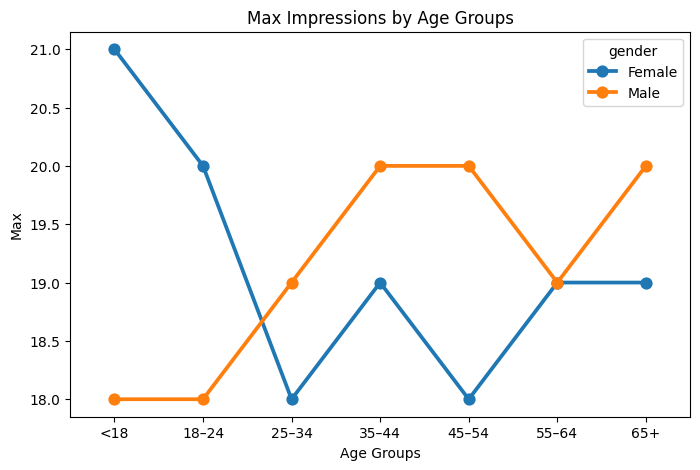

In [25]:
plt.figure(figsize=(8, 5))

sns.pointplot(data=summary_df, x="age_group", y="impressions_max", hue="gender")

plt.title("Max Impressions by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Max");

In [26]:
# додавання нового стовпчика з максимальним значенням по клікам
summary_df["clicks_max"] = (
    nyt_df[["clicks", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .max()
    .reset_index()["clicks"]
)
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean,clicks_mean,impressions_max,clicks_max
0,<18,Female,28716727,815692,2.840477,35.205356,5.001498,0.142066,21,6
1,<18,Male,1373095,40964,2.983333,33.519554,5.002350,0.149237,18,4
2,18–24,Female,2567289,28547,1.111951,89.932007,4.999424,0.055591,20,4
3,18–24,Male,2851414,31854,1.117130,89.515100,4.998841,0.055844,18,3
4,25–34,Female,3960583,39757,1.003817,99.619765,4.998111,0.050172,18,3
5,25–34,Male,4403825,44078,1.000903,99.909819,4.996772,0.050013,19,3
6,35–44,Female,4784496,48064,1.004578,99.544274,5.000210,0.050231,19,3
7,35–44,Male,5328839,53184,0.998041,100.196281,4.996029,0.049862,20,4
8,45–54,Female,4428835,44851,1.012704,98.745513,4.995652,0.050591,18,3
9,45–54,Male,4915835,49126,0.999342,100.065851,4.996407,0.049931,20,3


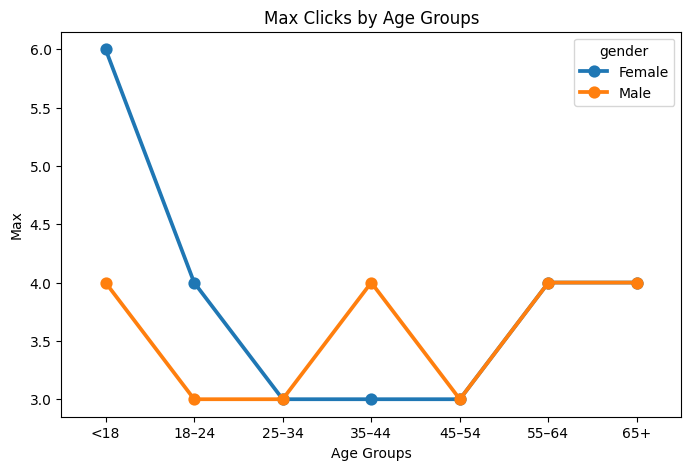

In [27]:
plt.figure(figsize=(8, 5))

sns.pointplot(data=summary_df, x="age_group", y="clicks_max", hue="gender")

plt.title("Max Clicks by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Max");

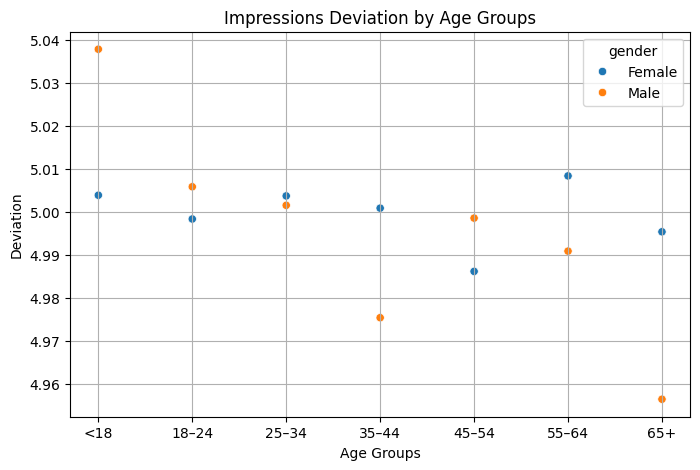

In [28]:
# додавання нового стовпчика з дисперсією по показам
summary_df["impressions_deviation"] = (
    nyt_df[["impressions", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .var()
    .reset_index()["impressions"]
)

plt.figure(figsize=(8, 5))

sns.scatterplot(data=summary_df, x="age_group", y="impressions_deviation", hue="gender")

plt.title("Impressions Deviation by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Deviation")
plt.grid(True);

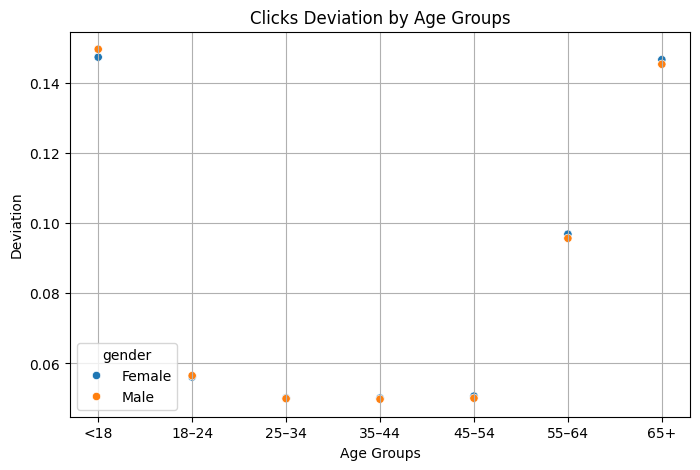

In [29]:
# додавання нового стовпчика з дисперсією по переходам
summary_df["clicks_deviation"] = (
    nyt_df[["clicks", "gender", "age_group"]]
    .groupby(["age_group", "gender"], observed=False)
    .var()
    .reset_index()["clicks"]
)

plt.figure(figsize=(8, 5))

sns.scatterplot(data=summary_df, x="age_group", y="clicks_deviation", hue="gender")

plt.title("Clicks Deviation by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Deviation")
plt.grid(True);

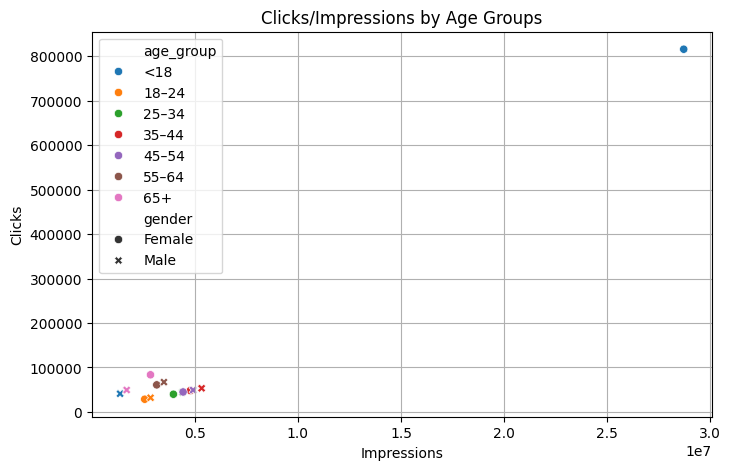

In [37]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=summary_df,
    x="impressions",
    y="clicks",
    hue="age_group",
    style="gender",
)

plt.title("Clicks/Impressions by Age Groups")
plt.xlabel("Impressions")
plt.ylabel("Clicks")
plt.grid(True);

In [31]:
summary_adults_df = summary_df[summary_df["age_group"] != "<18"]
summary_adults_df.reset_index(inplace=True, drop=True)
# summary_adults_df["age_group"] = summary_adults_df.age_group.cat.remove_categories("<18")
summary_adults_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean,clicks_mean,impressions_max,clicks_max,impressions_deviation,clicks_deviation
0,18–24,Female,2567289,28547,1.111951,89.932007,4.999424,0.055591,20,4,4.998391,0.056142
1,18–24,Male,2851414,31854,1.117130,89.515100,4.998841,0.055844,18,3,5.005894,0.056529
2,25–34,Female,3960583,39757,1.003817,99.619765,4.998111,0.050172,18,3,5.003765,0.050161
3,25–34,Male,4403825,44078,1.000903,99.909819,4.996772,0.050013,19,3,5.001576,0.049962
4,35–44,Female,4784496,48064,1.004578,99.544274,5.000210,0.050231,19,3,5.000916,0.050137
5,35–44,Male,5328839,53184,0.998041,100.196281,4.996029,0.049862,20,4,4.975421,0.049804
6,45–54,Female,4428835,44851,1.012704,98.745513,4.995652,0.050591,18,3,4.986197,0.050696
7,45–54,Male,4915835,49126,0.999342,100.065851,4.996407,0.049931,20,3,4.998601,0.050087
8,55–64,Female,3150708,60835,1.930836,51.791041,5.002505,0.096590,19,4,5.008423,0.096882
9,55–64,Male,3499641,67013,1.914854,52.223315,4.996175,0.095669,19,4,4.990917,0.095697


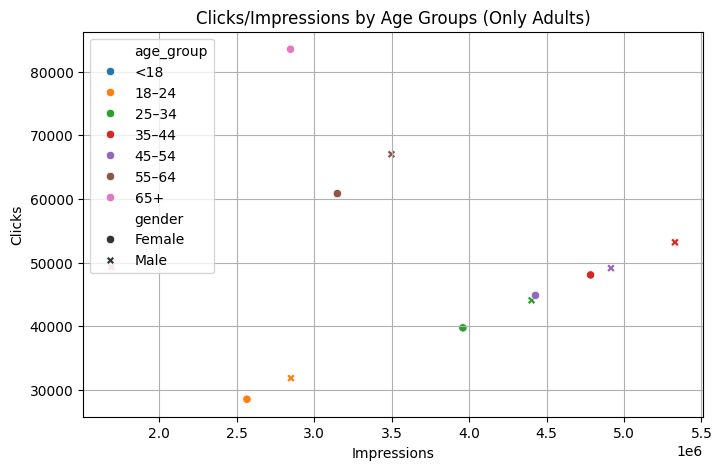

In [32]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=summary_adults_df,
    x="impressions",
    y="clicks",
    hue="age_group",
    style="gender",
)

plt.title("Clicks/Impressions by Age Groups (Only Adults)")
plt.xlabel("Impressions")
plt.ylabel("Clicks")
plt.grid(True);

In [33]:
summary_df

,age_group,gender,impressions,clicks,ctr,impressions_to_click,impressions_mean,clicks_mean,impressions_max,clicks_max,impressions_deviation,clicks_deviation
0,<18,Female,28716727,815692,2.840477,35.205356,5.001498,0.142066,21,6,5.003923,0.147367
1,<18,Male,1373095,40964,2.983333,33.519554,5.002350,0.149237,18,4,5.037905,0.149633
2,18–24,Female,2567289,28547,1.111951,89.932007,4.999424,0.055591,20,4,4.998391,0.056142
3,18–24,Male,2851414,31854,1.117130,89.515100,4.998841,0.055844,18,3,5.005894,0.056529
4,25–34,Female,3960583,39757,1.003817,99.619765,4.998111,0.050172,18,3,5.003765,0.050161
5,25–34,Male,4403825,44078,1.000903,99.909819,4.996772,0.050013,19,3,5.001576,0.049962
6,35–44,Female,4784496,48064,1.004578,99.544274,5.000210,0.050231,19,3,5.000916,0.050137
7,35–44,Male,5328839,53184,0.998041,100.196281,4.996029,0.049862,20,4,4.975421,0.049804
8,45–54,Female,4428835,44851,1.012704,98.745513,4.995652,0.050591,18,3,4.986197,0.050696
9,45–54,Male,4915835,49126,0.999342,100.065851,4.996407,0.049931,20,3,4.998601,0.050087
